<a href="https://colab.research.google.com/github/SwarajShinde/Deep-Learning-Reproduce/blob/master/GIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_json("/content/drive/My Drive/machine_hack/embold_train.json")
test = pd.read_json("/content/drive/My Drive/machine_hack/embold_test.json")

In [4]:
from sklearn.metrics import accuracy_score
import torch
from tqdm.notebook import tqdm

In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [6]:
!pip install transformers
import transformers
from transformers import AdamW


     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 3.0MB 16.8MB/s 
     |████████████████████████████████| 1.1MB 27.1MB/s 
     |████████████████████████████████| 890kB 39.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c780199bb87b935171a092985cce13cd2c9ab350f60f3ab243bed55d832a0810
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [36]:
class CONFIG:
    DEVICE = 'cuda'
    bert_path = 'bert-base-uncased'
    tokenizer = transformers.BertTokenizer.from_pretrained(bert_path, do_lower_case=True)
    MAX_LEN = 512
    train_batch_size = 8
    valid_batch_size = 8
    model_path = '/content/'
    epochs = 5
    num_folds = 5



In [10]:
class Train_dataset(Dataset):
    def __init__(self,title,label,max_len):
        self.title = title
        self.label = label
        self.max_len = CONFIG.MAX_LEN
        self.tokenizer = CONFIG.tokenizer
    def __len__(self):
        return len(self.title)
    def __getitem__(self,idx):
        review = str(self.title[idx])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length = self.max_len,
            padding = 'max_length'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        targets = self.label[idx]
        return {
            "ids":torch.tensor(ids,dtype=torch.long),
            "mask":torch.tensor(mask,dtype=torch.long),
            "token_type_ids":torch.tensor(token_type_ids,dtype=torch.long),
            "targets":torch.tensor(targets,dtype=torch.float)
        }


In [11]:
class Test_dataset(Dataset):
    def __init__(self,title,max_len):
        self.title = title
        self.max_len = CONFIG.MAX_LEN
        self.tokenizer = CONFIG.tokenizer
    def __len__(self):
        return len(self.title)
    def __getitem__(self,idx):
        review = str(self.title[idx])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length = self.max_len,
            padding = 'max_length'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        return {
            "ids":torch.tensor(ids,dtype=torch.long),
            "mask":torch.tensor(mask,dtype=torch.long),
            "token_type_ids":torch.tensor(token_type_ids,dtype=torch.long),
        }


In [14]:
def loss_fn(outputs,targets):
    return nn.CrossEntropyLoss()(outputs,targets)

In [15]:
def train_fn(model,train_loader,optimizer,device):
    model.train()
    tk0 = tqdm(train_loader,total = len(train_loader))
    for n,data in enumerate(tk0):
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets'] 
        ids = ids.to(device,dtype=torch.long)
        mask = mask.to(device,dtype=torch.long)
        token_type_ids = token_type_ids.to(device,dtype=torch.long)
        targets = targets.to(device,dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
        loss = loss_fn(outputs,targets)
        #print(f'Training loss {loss.item()} training Batch {n}')
        loss.backward()
        optimizer.step()
        model.zero_grad()


In [16]:
def eval_fn(model,eval_loader,optimizer,device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    tk0 = tqdm(eval_loader,total = len(eval_loader))
    with torch.no_grad():        
        for id,data in enumerate(tk0):
            ids = data['ids']
            mask = data['mask']
            token_type_ids = data['token_type_ids']
            targets = data['targets'] 
            ids = ids.to(device,dtype=torch.long)
            mask = mask.to(device,dtype=torch.long)
            token_type_ids = token_type_ids.to(device,dtype=torch.long)
            targets = targets.to(device,dtype=torch.long)
            outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
            loss = loss_fn(outputs,targets)
            sig_op = torch.argmax(torch.sigmoid(outputs),axis=1)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(sig_op.cpu().detach().numpy().tolist())
            #print(f'Valdition Loss {loss.item()} Val Accuracy :')
    return fin_outputs,fin_targets

In [17]:
def test_fn(model,test_loader,optimizer,device):
    model.eval()
    pred_targets = []
    pred_outputs = []
    tk0 = tqdm(test_loader,total = len(test_loader))
    with torch.no_grad():        
        for id,data in enumerate(tk0):
            ids = data['ids']
            mask = data['mask']
            token_type_ids = data['token_type_ids']
            ids = ids.to(device,dtype=torch.long)
            mask = mask.to(device,dtype=torch.long)
            token_type_ids = token_type_ids.to(device,dtype=torch.long)
            outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
            sig_op = torch.argmax(torch.sigmoid(outputs),axis=1)
            pred_outputs.extend(sig_op.cpu().detach().numpy().tolist())
            #print(f'Valdition Loss {loss.item()} Val Accuracy :')
    return pred_outputs

    # make some changes ie save the argmax of o/p , not only the sigmoids

In [18]:
class BertModel(nn.Module):
    def __init__(self):
        super(BertModel,self).__init__()
        self.bert = transformers.BertModel.from_pretrained(CONFIG.bert_path)
        self.drop = nn.Dropout(0.2)
        self.out = nn.Linear(768,3)
    def forward(self,ids,mask,token_type_ids):
        _,op = self.bert(ids,attention_mask = mask,token_type_ids = token_type_ids)
        x = self.drop(op)
        output = self.out(x)
        return output


In [19]:
train['kfold']  =-1
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
train = train.sample(frac=1).reset_index(drop=True)
y=train['label'].values
for n,(t_idx,val_idx) in enumerate(skf.split(X=train,y=y)):
    train.loc[val_idx,'kfold'] = n
train['kfold'].value_counts()

4    30000
3    30000
2    30000
1    30000
0    30000
Name: kfold, dtype: int64

In [23]:
def run_single_fold(train,test,fold_num,device):
    train = train.fillna("none")
    train_df = train[train['kfold']!=fold_num]
    valid_df = train[train['kfold']==fold_num]
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    print(f"train dataframe shape {train_df.shape}")
    print(f"train dataframe shape {valid_df.shape}")
    train_ds = Train_dataset(train_df['title'][:500],train_df['label'][:500],max_len=CONFIG.MAX_LEN)
    valid_ds = Train_dataset(valid_df['title'][:500],valid_df['label'][:500],max_len=CONFIG.MAX_LEN)
    train_loader = DataLoader(train_ds,batch_size=CONFIG.train_batch_size,num_workers=2,shuffle=True)
    valid_loader = DataLoader(valid_ds,batch_size=CONFIG.valid_batch_size,num_workers=2,shuffle=False)
    device = torch.device(CONFIG.DEVICE)
    model = BertModel()
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=3e-5,correct_bias=False)
    best_accuracy = 0
    for epoch in range(2):
        train_fn(model=model,train_loader=train_loader,optimizer=optimizer,device=device)
        outputs,targets = eval_fn(model,valid_loader,optimizer,device=device)
        accuracy = accuracy_score(outputs,targets)
        print(outputs)
        print(targets)
        print(f"Accuracy Score {accuracy} Epoch {epoch}")
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(),f"fold{fold_num}_seed{epoch}_train9.pth")

            # 5 fold training ; generate csv files for each , on a sample of data


In [24]:
run_single_fold(train,test,fold_num=1,device=CONFIG.DEVICE)

train dataframe shape (120000, 4)
train dataframe shape (30000, 4)



[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,


[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,

In [ ]:
!nvidia-smi
#killall python



In [ ]:
import torch, gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
clear_cache()

In [ ]:
tmp = torch.rand((8,3))

In [ ]:
test.shape


(30000, 2)

In [37]:
# lets test this stuff on test_data:
test_ds = Test_dataset(test['title'],max_len=CONFIG.MAX_LEN)
test_dl = DataLoader(test_ds,batch_size=CONFIG.valid_batch_size,shuffle=False,num_workers=2)


In [38]:
model = BertModel()
device = torch.device(CONFIG.DEVICE)
model.to(device)



BertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [39]:
model.load_state_dict(torch.load("/content/fold1_seed1_train9.pth"))
model.eval()
model.to(device)

BertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [40]:
prediction = test_fn(model=model,test_loader=test_dl,optimizer=optimizer,device=CONFIG.DEVICE)

In [29]:
optimizer = AdamW(model.parameters(), lr=3e-5,correct_bias=False)


In [41]:
len(prediction)

30000

In [ ]:
test_temp = test[:4000]


In [ ]:
test_temp['label2'] = prediction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_temp.to_csv('prediction_1_seed1_train2.csv',index=False)

In [ ]:
df_pred_1 = pd.read_csv("/content/prediction_1_seed1_train4.csv")

In [ ]:
test_temp['label'].value_counts()

1    2109
0    1739
2     152
Name: label, dtype: int64

In [ ]:
test_temp['label2'].value_counts()

1    2093
0    1907
Name: label2, dtype: int64

In [ ]:
test_temp.to_csv("test_temp",index=False)

In [ ]:
iilo = pd.read_csv("/content/test_temp")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


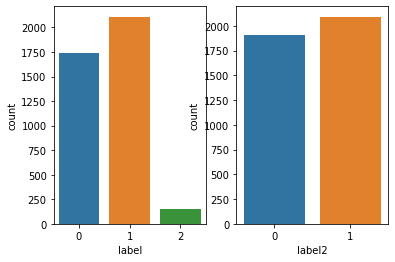

In [ ]:
fig,ax = plt.subplots(1,2)
sns.countplot(iilo['label'],ax=ax[0])
sns.countplot(iilo['label2'],ax=ax[1])

In [42]:
submission_df = pd.DataFrame(prediction,columns=['label'])

In [43]:
submission_df.to_csv('20k_1_sub.csv',index=False)

In [ ]:
print('jeck')

jeck
